# Batch: Human breast cancer datasets

We analyzed the two human breast cancer datasets for integrate multiple datasets. Two breast cancer datasets can be obtained from 10x Genomics Data Repository (https://www.10xgenomics.com/cn/resources/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0 and https://www.10xgenomics.com/cn/resources/datasets/human-breast-cancer-block-a-section-2-1-standard-1-1-0).

## 1. Import packages

In [1]:
from matplotlib import pyplot as plt
from DeepGFT.utils import *
from DeepGFT.genenet import obtain_genenet
from DeepGFT.train import *
import torch
import scanpy as sc
import warnings
from sklearn.metrics import adjusted_rand_score

warnings.filterwarnings('ignore')
os.environ['R_HOME'] = '/users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/R'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_all(2023)

/users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Read data

In [2]:
# Read data
name = 'BatchHBC'
adata = sc.read_h5ad('/fs/ess/PAS1475/Jixin/DeepGFT_proj/data/batch_Breast_Cancer/batch_Breast_Cancer.h5ad')

## 3. Data processing, including filtering genes and identifying svgs

In [3]:
# Data preprocessing
adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)
adata, adata_raw = svg(adata, svg_method='gft_top', n_top=3000, csvg=0.1)

## 4. Construct network and GFT

Construct spot-spot network and gene co-expression network, and the graph Fourier transform was performed respectively. Obtain signal features of spots and genes.

In [4]:
# Build spotnet and genenet
obtain_spotnet(adata, knn_method='Radius', rad_cutoff=350, prune=False)
gene_freq_mtx, gene_eigvecs_T, gene_eigvals = f2s_gene(adata, gene_signal=1500, c1=0.5)
obtain_genenet(adata, dataset='pearson', species='human')
spot_freq_mtx, spot_eigvecs_T, spot_eigvals = f2s_spot(adata, spot_signal=1500, middle=3, c2=0.001)
obtain_pre_spotnet(adata, adata_raw)

gene edges 291100 spots 7785


## 5. Train GAT module

In [5]:
# Train GAT
res, lamda, emb_spot, _, attention = train_spot(adata, gene_freq_mtx, gene_eigvecs_T, spot_freq_mtx, spot_eigvecs_T,
                                                alpha=20, device=device, epoch_max=800)

spot*signal train


100%|██████████| 800/800 [01:28<00:00,  9.07it/s]


## 6. Downstream analysis

### Batch effect in two slices

In [6]:
# Cluster and plot
adata.obsm['emb'] = emb_spot
cluster_num = 20
sc.pp.neighbors(adata, use_rep='emb')
sc.tl.leiden(adata, resolution=0.43)

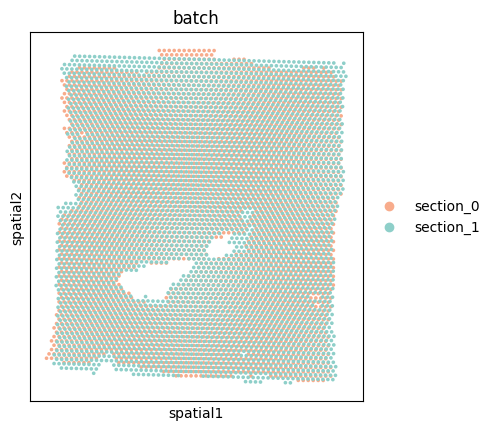

In [7]:
adata.uns['batch_colors'] = np.array(['#F8AC8C', '#8ECFC9'])
sc.pl.spatial(adata, color=['batch'], spot_size=200)

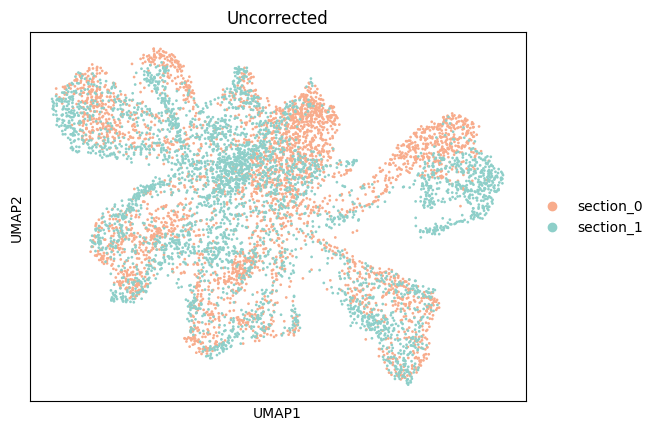

In [8]:
sc.pp.pca(adata_raw)
sc.pp.neighbors(adata_raw, use_rep='X_pca')
sc.tl.umap(adata_raw)
adata_raw.uns['batch_colors'] = np.array(['#F8AC8C', '#8ECFC9'])
sc.pl.umap(adata_raw, color='batch', title='Uncorrected')

### Eliminate batch effects and spatial cluster

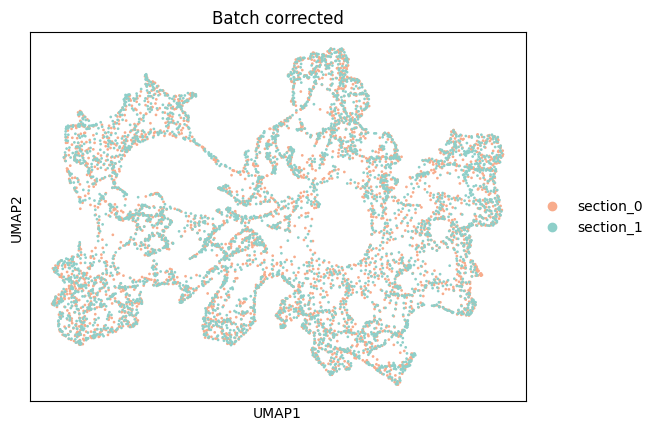

In [9]:
sc.pp.neighbors(adata, use_rep='emb')
sc.tl.umap(adata)
adata.uns['batch_colors'] = np.array(['#F8AC8C', '#8ECFC9'])
sc.pl.umap(adata, color='batch', title='Batch corrected')

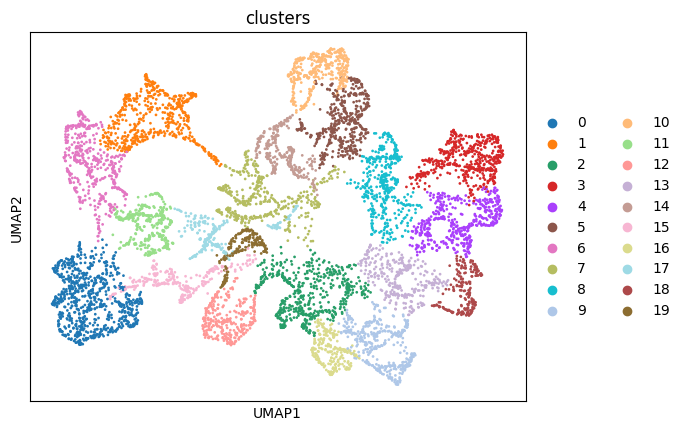

<Figure size 640x480 with 0 Axes>

In [10]:
sc.pl.umap(adata, color='leiden', title='clusters')
plt.tight_layout(w_pad=0.02)

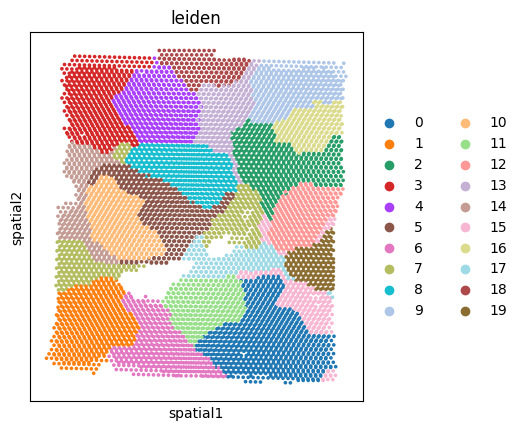

In [11]:
sc.pl.spatial(adata, color=["leiden"], title='leiden', spot_size=200)

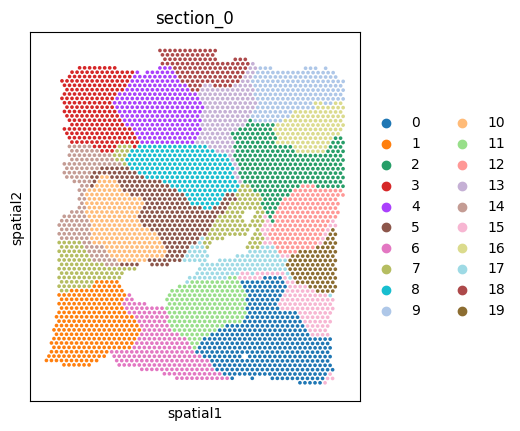

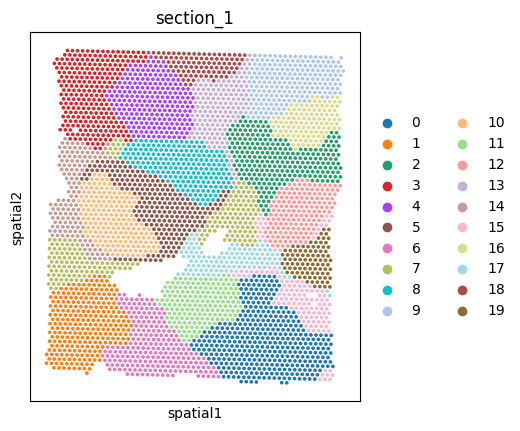

In [12]:
adata_0 = adata[adata.obs['batch']=='section_0',:]
sc.pl.spatial(adata_0, color=["leiden"], title='section_0', spot_size=200)
adata_1 = adata[adata.obs['batch']=='section_1',:]
sc.pl.spatial(adata_1, color=["leiden"], title='section_1', spot_size=200)